In [1]:
import numpy as np
import pandas as pd
from category_encoders import BinaryEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import joblib


In [2]:
pd.set_option('display.max_columns', None)

train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv("Data/test.csv")

print('Training data number = {}'.format(train_data.shape[0]))
print('Test data number = {}\n'.format(test_data.shape[0]))
print(train_data.columns) 

Training data number = 25000
Test data number = 10000

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price'],
      dtype='object')


In [3]:
basic_drop_columns = [
    "listing_id",
    "title",
    "description",
    "original_reg_date",
    "reg_date",
    "fuel_type",
    "opc_scheme",
    "lifespan",
    "eco_category",
    "features",
    "accessories",
    "indicative_price",
]
_train_data = train_data.drop(columns=basic_drop_columns)
print(_train_data.columns)


Index(['make', 'model', 'manufactured', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv',
       'arf', 'price'],
      dtype='object')


In [4]:
def min_max_scaler(
    data: pd.DataFrame, column_name: str, scaler: MinMaxScaler, refit: bool = False
) -> pd.DataFrame:
    if refit:
        data[column_name] = scaler.fit_transform(
            data[column_name].values.reshape(-1, 1)
        )
    else:
        data[column_name] = scaler.transform(data[column_name].values.reshape(-1, 1))
    return data


def standard_scaler(
    data: pd.DataFrame, column_name: str, scaler: StandardScaler, refit: bool = False
) -> pd.DataFrame:
    if refit:
        data[column_name] = scaler.fit_transform(
            data[column_name].values.reshape(-1, 1)
        )
    else:
        data[column_name] = scaler.transform(data[column_name].values.reshape(-1, 1))
    return data


def binary_encoder(
    data: pd.DataFrame, column_name: str, encoder: BinaryEncoder, refit: bool = False
) -> pd.DataFrame:
    if refit:
        labels = encoder.fit_transform(data[column_name])
    else:
        labels = encoder.transform(data[column_name])
    labels = pd.DataFrame(labels)
    data.drop(columns=[column_name], inplace=True)
    return pd.concat([data, labels], axis=1)


def onehot_encoder(
    data: pd.DataFrame, column_name: str, encoder: OneHotEncoder, refit: bool = False
) -> pd.DataFrame:
    if refit:
        labels = encoder.fit_transform(data[column_name])
    else:
        labels = encoder.transform(data[column_name])
    labels = pd.DataFrame(labels)
    data.drop(columns=[column_name], inplace=True)
    return pd.concat([data, labels], axis=1)

def ordinal_encoder(
    data: pd.DataFrame, column_name: str, encoder: OrdinalEncoder, refit: bool = False
) -> pd.DataFrame:
    if refit:
        labels = encoder.fit_transform(pd.DataFrame(data[column_name]))
    else:
        labels = encoder.transform(pd.DataFrame(data[column_name]))
    labels = labels.ravel()
    labels = pd.DataFrame(labels, columns=[column_name])
    data.drop(columns=[column_name], inplace=True)
    return pd.concat([data, labels], axis=1)

def target_encoder(
    data: pd.DataFrame, column_name: str, encoder: TargetEncoder, refit: bool = False
) -> pd.DataFrame:
    if refit:
        labels = encoder.fit_transform(data[column_name], data["price"])
    else:
        labels = encoder.transform(data[column_name])
    labels = pd.DataFrame(labels)
    data.drop(columns=[column_name], inplace=True)
    return pd.concat([data, labels], axis=1)

def multi_label_binarizer(
    data: pd.DataFrame,
    column_name: str,
    encoder: MultiLabelBinarizer,
    refit: bool = False,
) -> pd.DataFrame:
    data[column_name] = data[column_name].map(
        lambda c: [_c.strip() for _c in c.split(",") if _c != "" and _c != "-"]
    )
    if refit:
        labels = encoder.fit_transform(data[column_name]).astype(np.float64)
    else:
        labels = encoder.transform(data[column_name]).astype(np.float64)
    labels = pd.DataFrame(
        labels, columns=[column_name + "_" + c for c in encoder.classes_]
    )
    data.drop(columns=[column_name], inplace=True)
    return pd.concat([data, labels], axis=1)


other_drop_columns = [
    # "make",
    # "model",
    # "manufactured",
    # "type_of_vehicle",
    # "category",
    # "transmission",
    # "curb_weight",
    # "power",
    # "fuel_type",
    # "engine_cap",
    # "no_of_owners",
    # "depreciation",
    # "coe",
    # "road_tax",
    # "dereg_value",
    # "mileage",
    # "omv",
    # "arf",
    # "opc_scheme",
    # "price",
]

column_encoders = {
    # "make": (binary_encoder, BinaryEncoder()),
    "make": (ordinal_encoder, OrdinalEncoder()),
    # "model": (binary_encoder, BinaryEncoder()),
    "model": (ordinal_encoder, OrdinalEncoder()),
    "manufactured": (min_max_scaler, MinMaxScaler()),
    # "type_of_vehicle": (binary_encoder, BinaryEncoder()),
    "type_of_vehicle": (ordinal_encoder, OrdinalEncoder()),
    "category": (multi_label_binarizer, MultiLabelBinarizer()),
    "transmission": (ordinal_encoder, OrdinalEncoder()),
    "curb_weight": (standard_scaler, StandardScaler()),
    "power": (min_max_scaler, MinMaxScaler()),
    "engine_cap": (min_max_scaler, MinMaxScaler()),
    "no_of_owners": (min_max_scaler, MinMaxScaler()),
    "depreciation": (min_max_scaler, MinMaxScaler()),
    "coe": (min_max_scaler, MinMaxScaler()),
    "road_tax": (min_max_scaler, MinMaxScaler()),
    "dereg_value": (min_max_scaler, MinMaxScaler()),
    "mileage": (min_max_scaler, MinMaxScaler()),
    "omv": (min_max_scaler, MinMaxScaler()),
    "arf": (min_max_scaler, MinMaxScaler()),
    "price": (min_max_scaler, MinMaxScaler()),
}


def preprocess_data(data: pd.DataFrame, is_train_data: bool = False, test_size = 0.2):
    data = data.drop(columns=other_drop_columns)
    
    if is_train_data:
        # data = data.dropna()
        data = data.drop_duplicates()
        for column_name in data.columns:
            if data[column_name].dtype == "object":
                data[column_name].fillna("", inplace=True)
            else:
                data[column_name].fillna(
                    data[column_name].mean(),
                    inplace=True,    
                )
        
    data = data.reset_index(drop=True)

    for column_name in data.columns:
        # print("====================================={}================================".format(column_name))
        assert column_name in column_encoders, f"Column {column_name} not found in column_encoders."
        prefunc, encoder = column_encoders[column_name]
        data = prefunc(data, column_name, encoder, is_train_data)

    if is_train_data:
        X = data.drop(columns=["price"])
        Y = data["price"]
        train_X, valid_X, train_Y, valid_Y = train_test_split(
            X, Y, test_size=test_size, random_state=35
        )
        return train_X, valid_X, train_Y, valid_Y
    else:
        return data, None, None, None

In [5]:
train_X, valid_X, train_Y, valid_Y = preprocess_data(_train_data, is_train_data=True)
print(train_X.columns)


Index(['manufactured', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv',
       'arf', 'make', 'model', 'type_of_vehicle', 'category_almost new car',
       'category_coe car', 'category_consignment car',
       'category_direct owner sale', 'category_electric cars',
       'category_hybrid cars', 'category_imported used vehicle',
       'category_low mileage car', 'category_opc car', 'category_parf car',
       'category_premium ad car', 'category_rare & exotic',
       'category_sgcarmart warranty cars', 'category_sta evaluated car',
       'category_vintage cars', 'transmission'],
      dtype='object')


In [6]:
# 使用lgb进行训练
lgb_train_data = lgb.Dataset(train_X, label = train_Y)
params = {
    "metric": "rmse",
}
model = lgb.train(params, lgb_train_data)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 19994, number of used features: 31
[LightGBM] [Info] Start training from score 0.039295


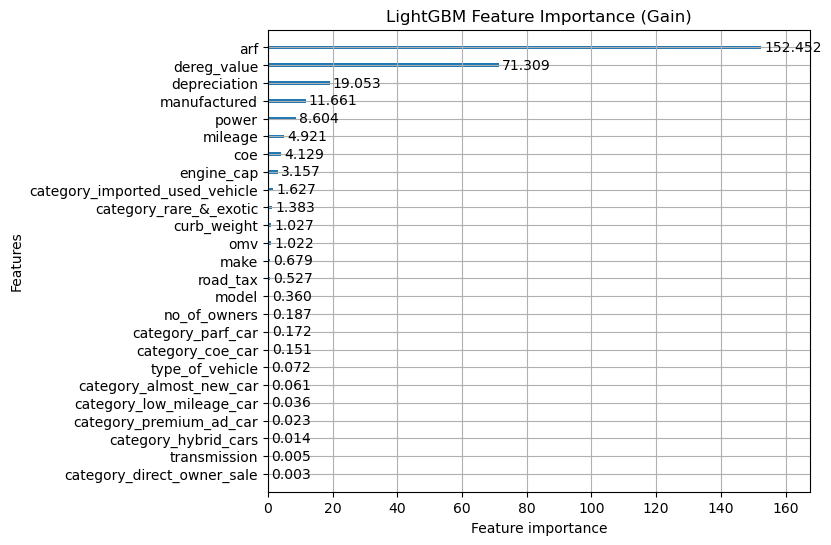

<Axes: title={'center': 'LightGBM Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

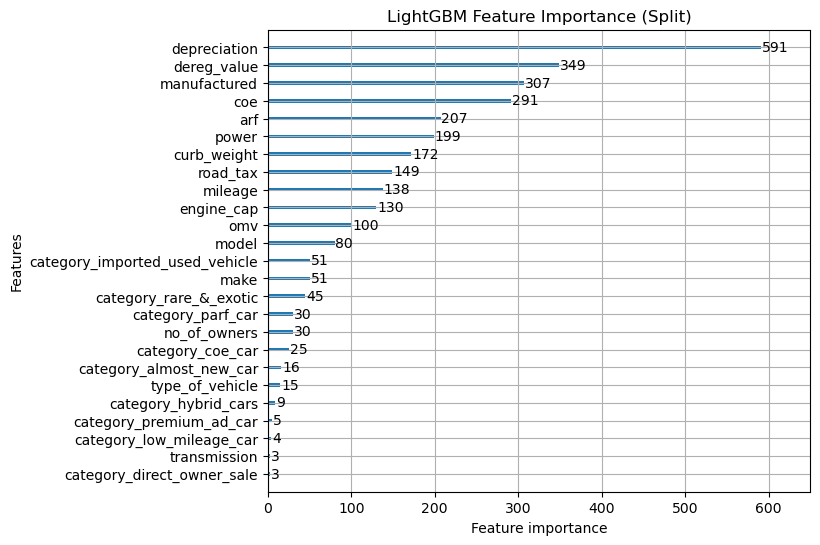

In [7]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")

In [8]:
kept_columns = [
    "depreciation",
    "dereg_value",
    "manufactured",
    "coe",
    "power",
    "category",
    "arf",
    "mileage",
    "omv",
    "price",
]
_train_data = train_data[kept_columns]
train_X, valid_X, train_Y, valid_Y = preprocess_data(_train_data, is_train_data=True)

kf = KFold(n_splits=5, shuffle=True, random_state=35)
models = []
for train_part_indices, test_part_indices in kf.split(train_X, train_Y):
    _train_X = train_X.iloc[train_part_indices]
    _train_Y = train_Y.iloc[train_part_indices]
    _valid_X = train_X.iloc[test_part_indices]
    _valid_Y = train_Y.iloc[test_part_indices]
    lgb_train_data = lgb.Dataset(_train_X, label = _train_Y)
    lgb_valid_data = lgb.Dataset(_valid_X, label = _valid_Y)
    params = {
        "metric": "rmse",
    }
    model = lgb.train(params, lgb_train_data)
    models.append(model)
    
    _pred_Y = model.predict(_valid_X)
    _pred_Y = column_encoders["price"][1].inverse_transform(_pred_Y.reshape(-1, 1))
    _valid_Y = column_encoders["price"][1].inverse_transform(_valid_Y.values.reshape(-1, 1))
    print("model {} light gbm rmse: {}".format(len(models), np.sqrt(mean_squared_error(_valid_Y, _pred_Y))))
for idx, model in enumerate(models):
    joblib.dump(model, f"./modelCache/mymodel/model_{idx}.pkl")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 15992, number of used features: 23
[LightGBM] [Info] Start training from score 0.039397
model 1 light gbm rmse: 28909.938732854534
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 15992, number of used features: 23
[LightGBM] [Info] Start training from score 0.039537
model 2 light gbm rmse: 36704.18640087921
[LightGBM] [Warning] Found whitespace in feature_names, replace with un

In [302]:
def fill_test_data(_test_data: pd.DataFrame) -> pd.DataFrame:
    for column_name in _test_data.columns:
        if _test_data[column_name].dtype != "object":
            _test_data[column_name].fillna(
                _test_data[column_name].mean(),
                inplace=True,
            )
    return _test_data


_kept_columns = kept_columns.copy()
_kept_columns.remove("price")
_test_data = test_data[_kept_columns].copy()
_test_data = fill_test_data(_test_data)
_test_data_X, _, _, _ = preprocess_data(_test_data, is_train_data=False)

test_pred_Y = np.zeros((_test_data_X.shape[0], 1))
for model in models:
    test_pred_Y += model.predict(_test_data_X).reshape(-1, 1)
test_pred_Y /= len(models)
test_pred_Y = column_encoders["price"][1].inverse_transform(test_pred_Y)
res_df = pd.DataFrame({"Id": range(0, test_pred_Y.shape[0]), "Predicted": test_pred_Y.ravel()})
res_df.to_csv('result_2.csv', index=False)